# One Hundred Years of US Baby Names

## Bootcamp Project
### June 30, 2020

### Group
Dhara Bhansali
Sarah Grant
Keke Li
Matt Debnar

### Overview
Analysis of baby names in the US from 1910 thru 2014

In [1]:
# Dependencies
#from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
#from us import states
from scipy.stats import linregress
from matplotlib import pyplot as plt

In [2]:
#data source: https://www.kaggle.com/kaggle/us-baby-names
#import baby name data
baby_name_original = pd.read_csv(
    "Data/StateNames.csv", dtype="object", encoding="utf-8")
#display result
baby_name_original.head()

,Id,Name,Year,Gender,State,Count
0,1,Mary,1910,F,AK,14
1,2,Annie,1910,F,AK,12
2,3,Anna,1910,F,AK,10
3,4,Margaret,1910,F,AK,8
4,5,Helen,1910,F,AK,7


In [3]:
#clean up column formats for Count (float), Year (int), convert year to date in new column date_conv (datetime)
baby_name_original["Count"] = baby_name_original.Count.astype(float)
baby_name_original["Year"] = baby_name_original["Year"].astype(int)
#alternative: change year into datetime if desired as new column date_conv
#baby_name_original['date_conv'] = pd.to_datetime(baby_name_original.Year)

In [4]:
#look for null values
baby_name_original.isnull().sum()

Id        0
Name      0
Year      0
Gender    0
State     0
Count     0
dtype: int64

In [5]:
#add a new column for Decade
baby_name_new = baby_name_original.copy()
baby_name_new.set_index('Id', inplace=True)
#baby_name_new["Year"] = baby_name_new["Year"].astype(int)
baby_name_new['Decade'] = ((baby_name_new['Year']//10)*10)
#baby_name_new = baby_name_new.reset_index(drop=True)
baby_name_new

,Name,Year,Gender,State,Count,Decade
Id,,,,,,
1,Mary,1910,F,AK,14.0,1910
2,Annie,1910,F,AK,12.0,1910
3,Anna,1910,F,AK,10.0,1910
4,Margaret,1910,F,AK,8.0,1910
5,Helen,1910,F,AK,7.0,1910
...,...,...,...,...,...,...
5647422,Seth,2014,M,WY,5.0,2010
5647423,Spencer,2014,M,WY,5.0,2010
5647424,Tyce,2014,M,WY,5.0,2010


In [6]:
#Define Region by State values
Northeast = ('CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA')
Midwest = ('IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD')
South = ('DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'AR', 'OK', 'TX')
West = ('AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA')


In [7]:
#add column Region and assign based on region-state values
baby_name_new["Region"] = np.where(baby_name_new["State"].isin(Northeast), "Northeast", 
         (np.where(baby_name_new["State"].isin(South), "South",
            (np.where(baby_name_new["State"].isin(West), "West",
                (np.where(baby_name_new["State"].isin(Midwest), "Midwest", "Unknown")))))))

#confirm 4 regions across all data
baby_name_new.nunique()

Name      30274
Year        105
Gender        2
State        51
Count      4944
Decade       11
Region        4
dtype: int64

In [8]:
#find any Unkown regions to bug fix Region States
baby_unknown = baby_name_new.loc[baby_name_new["Region"] == "Unknown", :]
baby_unknown

,Name,Year,Gender,State,Count,Decade,Region
Id,,,,,,,


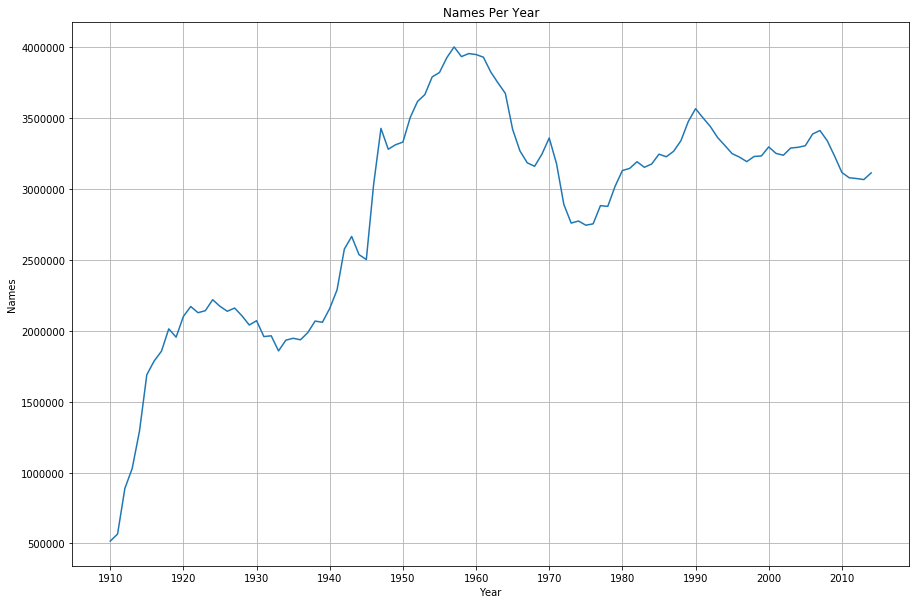

In [9]:
#summarize names per year
years = list(range(1910, 2011, 10))
plt.figure(figsize=(15,10))
plt.plot(baby_name_original.groupby(['Year']).agg({'Count':np.sum}))
plt.title("Names Per Year")
plt.xlabel('Year')
plt.ylabel('Names')
plt.xticks(years)
plt.grid()

plt.savefig(f'Output/Names Per Year.png')

### Observation: the baby boom is real! Count of names jumped at the end of WWII in 1945 and peaked just before 1960

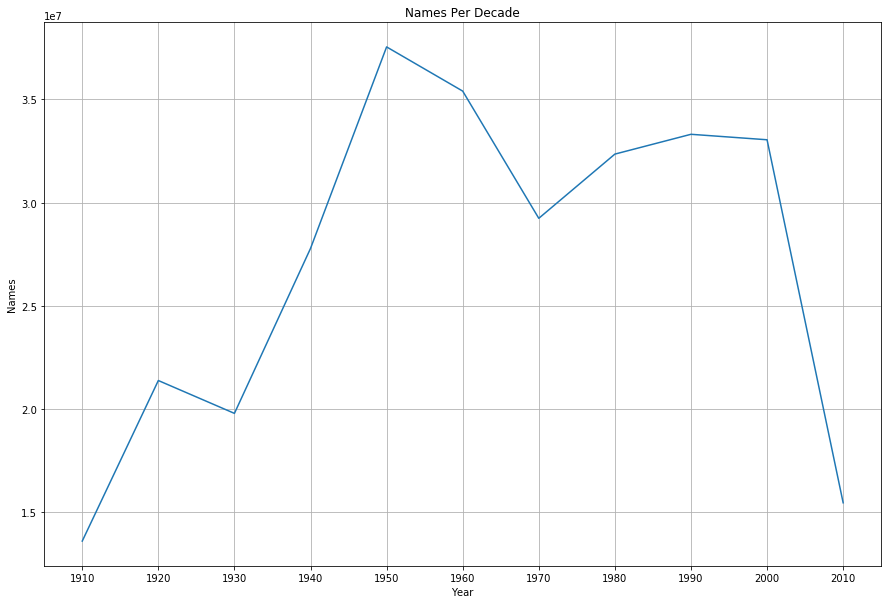

In [10]:
#optional names by Decade
years = list(range(1910, 2011, 10))
plt.figure(figsize=(15,10))
plt.plot(baby_name_new.groupby(['Decade']).agg({'Count':np.sum}))
plt.title("Names Per Decade")
plt.xlabel('Year')
plt.ylabel('Names')
plt.xticks(years)
plt.grid()

plt.savefig(f'Output/Names Per Decade.png')

### Observation: baby boom confirmed in 1950s then slight bounce back until 2000s (note: 2010 is a partial decade, only half thru 2014)

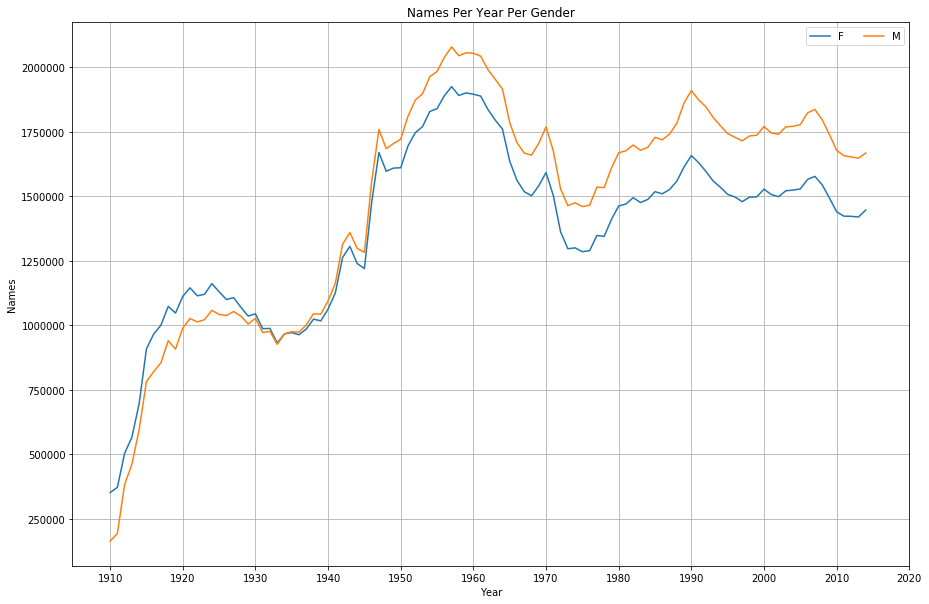

In [11]:
GenderNameGB = baby_name_new.groupby(['Year', 'Gender'])['Count'].sum()
GenderNameGBDF = pd.DataFrame(GenderNameGB)
GenderNameGBDF
GenderNameGBDF.rename(index={0: "Year", 1: "Gender", 2: "Count"})
GenderNameGBDFX = GenderNameGBDF.unstack()
GenderNameGBDFX.columns = GenderNameGBDFX.columns.droplevel()
GenderNameGBDFX
multi_plot = GenderNameGBDFX.plot(kind="line", figsize=(15, 10))
multi_plot.set_title("Names Per Year Per Gender")
multi_plot.set_xlabel('Year')
multi_plot.set_ylabel('Names')
multi_plot.legend(ncol=2)
years = list(range(1910, 2021, 10))
plt.xticks(years)
plt.grid()
plt.savefig(f'Output/Names Per Gender.png')

### Observation: girls names outpaced boys until 1930; after 1930 the number of boys' names outpaced girls' consistently thru 2014

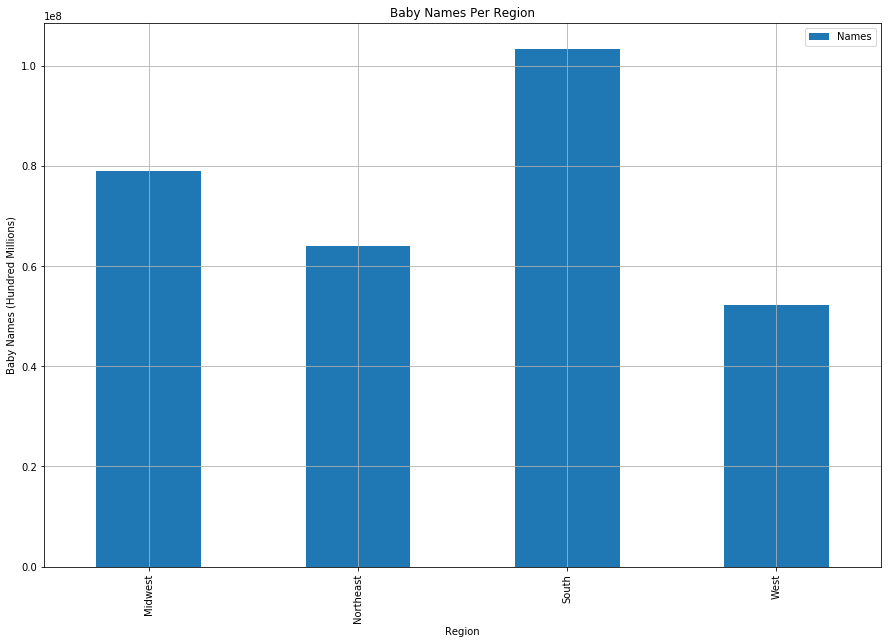

In [12]:
babyRegion = baby_name_new.groupby("Region")

Region = babyRegion.count().index
RegionNames = babyRegion['Count'].sum()

regionSummary = pd.DataFrame({"Region": Region, "Names": RegionNames,
                             })
regionSummary.set_index('Region', inplace=True)

multi_plot = regionSummary.plot(kind="bar", figsize=(15, 10))
plt.title(f"Baby Names Per Region")
plt.grid()
plt.xlabel("Region")
plt.ylabel("Baby Names (Hundred Millions)")
plt.savefig(f'Output/Names Per Region.png')

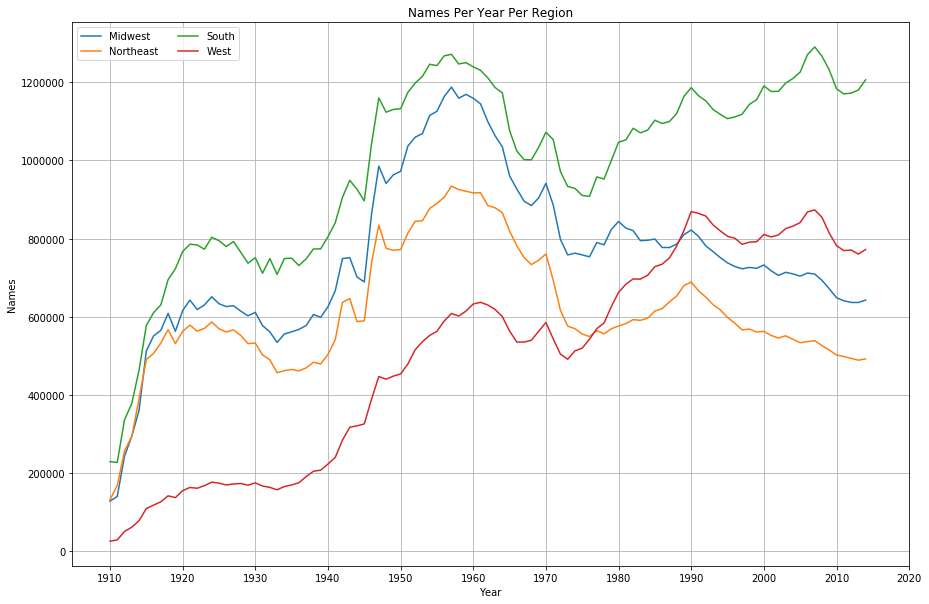

In [13]:
#names per region over time
RegionNameGB = baby_name_new.groupby(['Year', 'Region'])['Count'].sum()
RegionNameGBDF = pd.DataFrame(RegionNameGB)
RegionNameGBDF
RegionNameGBDF.rename(index={0: "Year", 1: "Region", 2: "Count"})
RegionNameGBDFX = RegionNameGBDF.unstack()
RegionNameGBDFX.columns = RegionNameGBDFX.columns.droplevel()
RegionNameGBDFX
multi_plot = RegionNameGBDFX.plot(kind="line", figsize=(15, 10))
multi_plot.set_title("Names Per Year Per Region")
multi_plot.set_xlabel('Year')
multi_plot.set_ylabel('Names')
multi_plot.legend(ncol=2)
years = list(range(1910, 2021, 10))
plt.xticks(years)
plt.grid()
plt.savefig(f'Output/Names Per Year Per Region.png')

### Observation: the South consitently registers the most names.  The Midwest and and Northeast counts peaked just before 1960 then fell off.  The West gained in name counts starting in 1940 then increased again in 1975 to gain second place

In [14]:
#group by Name to find popular names
BabyNameGB = baby_name_original.groupby("Name")
BabyName = BabyNameGB.count().index
NameCount = BabyNameGB["Count"].sum()

TopNameGB = pd.DataFrame({"Name": BabyName, "Popularity": NameCount
                             })
#sort names by popularity
TopName = TopNameGB.sort_values(by=['Popularity'], ascending=False)
TopName.head(10)

,Name,Popularity
Name,,
James,James,4957166.0
John,John,4845414.0
Robert,Robert,4725713.0
Michael,Michael,4312975.0
William,William,3839236.0
Mary,Mary,3740495.0
David,David,3562278.0
Richard,Richard,2534949.0
Joseph,Joseph,2485220.0


### Observation: most of the top names are Male. Given more Female names registered than Male suggests more variability in Female names than Male

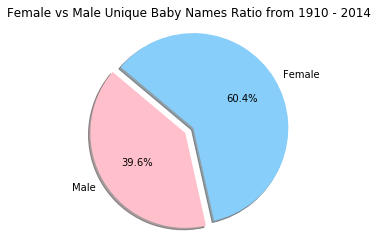

<Figure size 432x288 with 0 Axes>

In [15]:
# The names used by each gender (female has more diverse name selections/options than male)
name= baby_name_original.loc[:,['Name','Gender','Count']]
name

gendername= name.groupby(['Gender']).nunique()['Name']
gendername

Male= 13139
Female=20031

labels = ["Male", "Female"]

# The values of each section of the pie chart
sizes = [13139, 20031]

# The colors of each section of the pie chart
colors = ["pink","lightskyblue"]

explode = (0,0.1)

plt.pie(sizes, labels=labels,explode=explode, colors=colors, shadow=True, startangle=140,autopct="%1.1f%%")
plt.title(f"Female vs Male Unique Baby Names Ratio from 1910 - 2014")
plt.axis("equal")
plt.show()
# export as png

plt.savefig(f'Output/Female vs Male Unique Baby Names Ratio from 1910 - 2014.png')

### Proof! Female names have more variety than Male names

In [16]:
# Group the dataset by name
names = baby_name_original.groupby("Name")

# Different names in the database
baby_name_original.Name.nunique()


30274

In [17]:
# Name with the most occurances
most_occurances = names.Count.sum().sort_values(ascending=False)
most_occurances

Name
James       4957166.0
John        4845414.0
Robert      4725713.0
Michael     4312975.0
William     3839236.0
              ...    
Makua             5.0
Makinlee          5.0
Makenlie          5.0
Makenlee          5.0
Zyshonne          5.0
Name: Count, Length: 30274, dtype: float64

In [18]:
# Least occurances
least_occurances = (names.Count.sum()== 5).sum()
least_occurances

4722

In [20]:
# Top 10 Males Name
baby_name_male = baby_name_original[baby_name_original["Gender"] == "M"]
baby_name_male = baby_name_male[["Name", "Count"]]
baby_name_male = baby_name_male.groupby("Name")
baby_name_male = baby_name_male.sum()
baby_name_male = baby_name_male.sort_values("Count", ascending=False)
baby_name_male.head(10)

,Count
Name,
James,4938965.0
John,4829733.0
Robert,4710600.0
Michael,4295779.0
William,3829026.0
David,3554102.0
Richard,2529952.0
Joseph,2479602.0
Charles,2244617.0


In [21]:
# Top 10 Female Names

baby_name_female = baby_name_original[baby_name_original["Gender"] == "F"]
baby_name_female= baby_name_female[["Name", "Count"]]
baby_name_female = baby_name_female.groupby("Name")
baby_name_female = baby_name_female.sum()
baby_name_female = baby_name_female.sort_values("Count", ascending=False)
baby_name_female.head(10)

,Count
Name,
Mary,3730856.0
Patricia,1567779.0
Elizabeth,1500462.0
Jennifer,1461813.0
Linda,1446300.0
Barbara,1422972.0
Margaret,1121985.0
Susan,1108255.0
Dorothy,1051603.0


### Observation: counts of top Female names are lower than top Male names, reinforcing lower variety in Male names

In [22]:
# For creating tuples
males = [(male,'M') for male in list(baby_name_male.head(8).index)]
females = [(female,'F') for female in list(baby_name_female.head(8).index)]

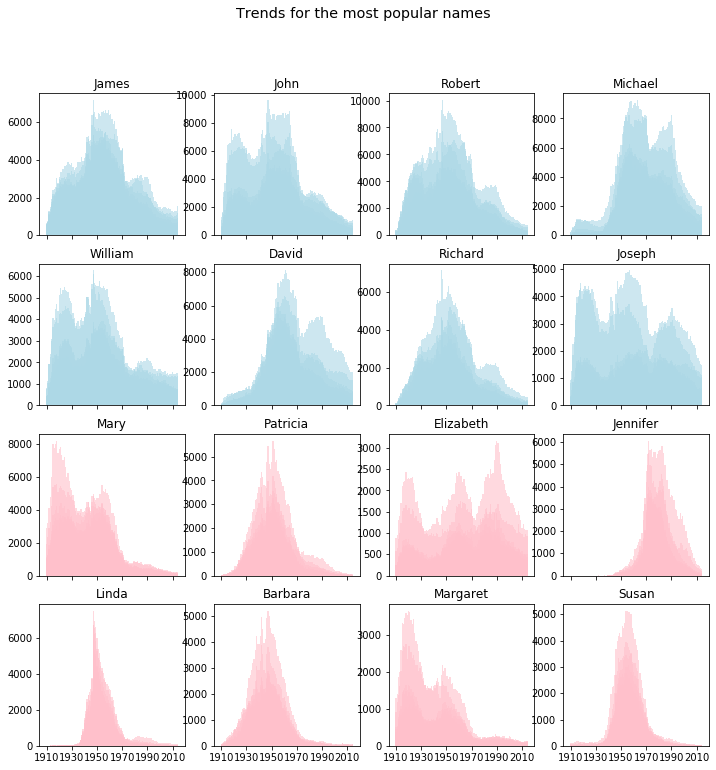

In [23]:
most_popular = baby_name_original

def plot(ax, name, gender):
    data = most_popular.loc[(most_popular.Name==name)&(most_popular.Gender==gender)]
    ax.bar(data.Year, data.Count, width = 1, alpha=0.6,
           color = 'pink' if gender=='F' else 'lightblue')
    ax.set_title(name)
    return ax

fig, ax = plt.subplots(4,4, figsize=(12,12), sharex=True)
ax = ax.flatten()
years = list(range(1910, 2021,20))
plt.xticks(years)
for a, (name, gender) in zip(ax, males+females):
    plot(a, name, gender)
fig.suptitle('Trends for the most popular names',fontsize='x-large');
plt.savefig("Output/Popular_Names.png")

### Observation: most Boys names peak around 1960; Joseph and Michael remain popular. Most Girls names also peak in 1950 or 1960, Elizabeth and Jennifer remain popular

In [24]:
baby_name_original["Name Length"]= baby_name_original["Name"].str.len()
baby_name_original

,Id,Name,Year,Gender,State,Count,Name Length
0,1,Mary,1910,F,AK,14.0,4
1,2,Annie,1910,F,AK,12.0,5
2,3,Anna,1910,F,AK,10.0,4
3,4,Margaret,1910,F,AK,8.0,8
4,5,Helen,1910,F,AK,7.0,5
...,...,...,...,...,...,...,...
5647421,5647422,Seth,2014,M,WY,5.0,4
5647422,5647423,Spencer,2014,M,WY,5.0,7
5647423,5647424,Tyce,2014,M,WY,5.0,4
5647424,5647425,Victor,2014,M,WY,5.0,6


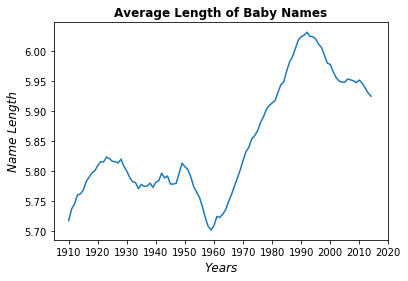

In [25]:
plt.plot(baby_name_original.groupby(['Year']).agg({'Name Length':np.mean}))
years = list(range(1910, 2021,10))
plt.xticks(years)
plt.xlabel("Years",fontsize=12,style='italic')
plt.ylabel("Name Length", fontsize=12,style='italic')
plt.title("Average Length of Baby Names",fontsize=12,fontweight='bold',style='normal')
plt.savefig("Output/NameLength.png")
plt.show()

### Observation: Baby name length increases from 1960 thru 1990

In [26]:
both_df = baby_name_original.groupby(['Year','Gender'])['Name Length'].mean()
both_df = both_df.unstack()

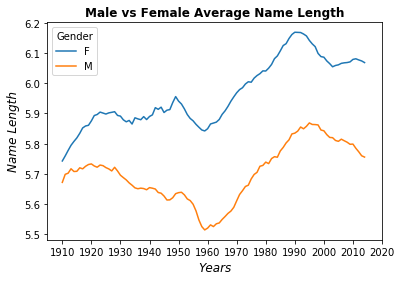

In [27]:
both_df.plot(kind = 'line')
years = list(range(1910, 2021,10))
plt.xticks(years)
plt.xlabel("Years",fontsize=12,style='italic')
plt.ylabel("Name Length",fontsize=12,style='italic')
plt.title("Male vs Female Average Name Length",fontsize=12,fontweight='bold',style='normal')
#plt.savefig("../Output/Male vs Female Name Length.png")
plt.savefig("Output/Male vs Female Name Length.png")
plt.show()

In [28]:
# Most popular Names Length
popular_name_length = baby_name_original.groupby(['Name','Name Length']).size().reset_index(name="Count").sort_values(by="Count",ascending=False).drop_duplicates("Name", keep="first")
print("The most popular Name Lengths:")
popular_name_length.head(20)

The most popular Name Lengths:


,Name,Name Length,Count
17369,Leslie,6,7194
17160,Lee,3,7125
12442,James,5,7037
13761,John,4,6865
23582,Robert,6,6820
13485,Jessie,6,6636
29049,William,7,6522
19955,Michael,7,6396
19273,Mary,4,6371
5174,Charles,7,6268


In [29]:
baby_name_new = baby_name_original.copy()
baby_name_new.set_index('Id', inplace=True)
#baby_name_new["Year"] = baby_name_new["Year"].astype(int)
baby_name_new['Decade'] = ((baby_name_new['Year']//10)*10)
#baby_name_new = baby_name_new.reset_index(drop=True)
baby_name_new

,Name,Year,Gender,State,Count,Name Length,Decade
Id,,,,,,,
1,Mary,1910,F,AK,14.0,4,1910
2,Annie,1910,F,AK,12.0,5,1910
3,Anna,1910,F,AK,10.0,4,1910
4,Margaret,1910,F,AK,8.0,8,1910
5,Helen,1910,F,AK,7.0,5,1910
...,...,...,...,...,...,...,...
5647422,Seth,2014,M,WY,5.0,4,2010
5647423,Spencer,2014,M,WY,5.0,7,2010
5647424,Tyce,2014,M,WY,5.0,4,2010


In [30]:
# Group the dataset by decade
decade = baby_name_new.groupby("Decade")

In [31]:
# Average per Decade 
average_decade = decade['Name Length'].mean()
print("The Average per decade is:")
average_decade

The Average per decade is:


Decade
1910    5.771876
1920    5.815646
1930    5.780017
1940    5.788889
1950    5.754392
1960    5.748616
1970    5.865854
1980    5.963152
1990    6.014065
2000    5.954859
2010    5.938594
Name: Name Length, dtype: float64

In [32]:
# Standard deviation of decade
std_decade= decade['Name Length'].std()
print("The Standard Deviation of decade on Name length is:")
std_decade

The Standard Deviation of decade on Name length is:


Decade
1910    1.471722
1920    1.470501
1930    1.462167
1940    1.465226
1950    1.452642
1960    1.439538
1970    1.419871
1980    1.420725
1990    1.397427
2000    1.364146
2010    1.368459
Name: Name Length, dtype: float64

In [33]:
# The average Name Length for 100 years
gender_name_length = baby_name_original["Name Length"]
average_name = np.average(gender_name_length)
print(" The average name length is:" + str(average_name))

 The average name length is:5.875933389831049


In [34]:
mean_series = baby_name_new.groupby(['Year'])['Name Length'].mean()
max_index = mean_series.argmax()
print("Maximum average value is %f"%mean_series.iloc[max_index])

# Year with maximum average length
print("Year with maximum length is %d"%mean_series.index[max_index])

#Top ten values in 1990
baby_name_new[baby_name_new['Year'] == 1990]

Maximum average value is 6.031970
Year with maximum length is 1992


,Name,Year,Gender,State,Count,Name Length,Decade
Id,,,,,,,
8496,Jessica,1990,F,AK,112.0,7,1990
8497,Ashley,1990,F,AK,96.0,6,1990
8498,Amanda,1990,F,AK,92.0,6,1990
8499,Brittany,1990,F,AK,75.0,8,1990
8500,Samantha,1990,F,AK,72.0,8,1990
...,...,...,...,...,...,...,...
5643677,Kaleb,1990,M,WY,5.0,5,1990
5643678,Kasey,1990,M,WY,5.0,5,1990
5643679,Keith,1990,M,WY,5.0,5,1990


In [35]:
print("The Longest Name Length for year 1990 :")
baby_name_new[baby_name_new['Year'] == 1990].sort_values('Name Length',ascending = False).head(10)[['Name','Name Length']]



The Longest Name Length for year 1990 :


,Name,Name Length
Id,,
470123,Mariadelcarmen,14
644729,Michaelanthony,14
644768,Antoniodejesus,14
470124,Mariaguadalupe,14
5024084,Michaelangelo,13
472164,Maryelizabeth,13
3822039,Michaelangelo,13
472149,Mariacristina,13
1701829,Michaelangelo,13


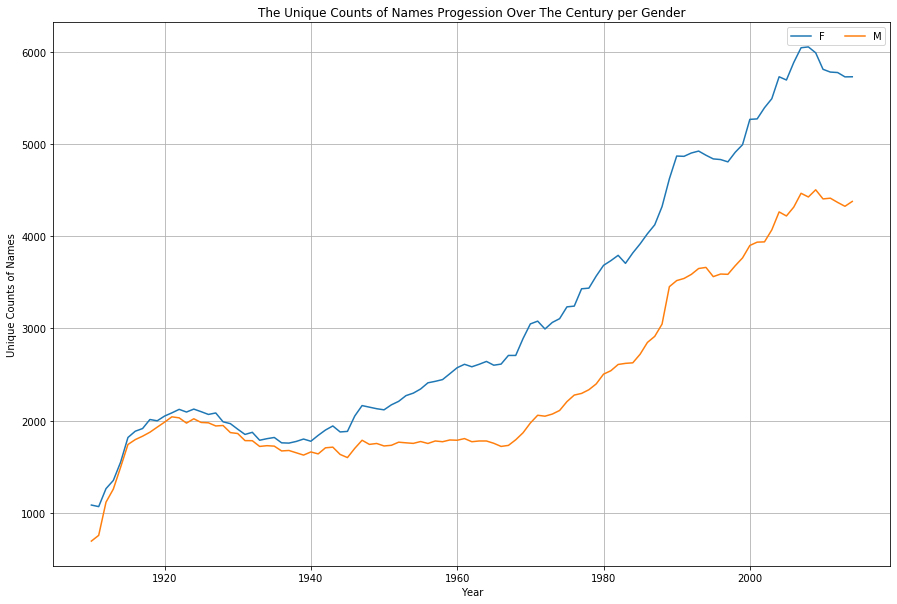

In [36]:
#The progression of numbers of unique names in each year


year= baby_name_original.loc[:,['Name','Year','Gender']]
year

# getting female list of unique name by each year

genderf= year.loc[year['Gender'] == 'F']
genderf

genderfemale= genderf.groupby(['Year','Gender']).nunique()['Name']


genderfemale= pd.DataFrame(genderfemale)
genderfemale

#getting male list of unique name by each year

genderm= year.loc[year['Gender'] == 'M']
genderm

gendermale= genderm.groupby(['Year','Gender']).nunique()['Name']

gendermale= pd.DataFrame(gendermale)
gendermale


final=pd.merge(genderfemale, gendermale, how='outer', on=['Year','Gender','Name'])
final

final.rename(index={0: "Year", 1: "Gender", 2: "Name"})
df = final.unstack()
df.columns =df.columns.droplevel()
df

multi_plot = df.plot(kind="line", figsize=(15, 10))
multi_plot.set_title("The Unique Counts of Names Progession Over The Century per Gender")
multi_plot.set_xlabel("Year")

multi_plot.set_ylabel("Unique Counts of Names")
multi_plot.legend(ncol=2)


years = list(range(1910, 2021, 10))

#plt.set_xticks(years)
plt.grid()


plt.savefig(f'Output/The Unique Counts of Names Progession Over The Century per Gender.png')

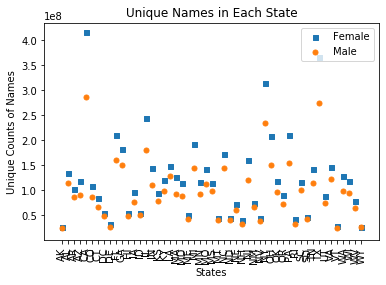

<Figure size 432x288 with 0 Axes>

In [37]:
# The progression of numbers of unique names by state in gender

region= baby_name_original.loc[:,['Name','Year','Gender','State']]
region



f= region.loc[region['Gender'] == 'F']
f

m= region.loc[region['Gender'] == 'M']
m


fgender= f.groupby(['State']).sum()
fgender = pd.DataFrame(fgender)
fgender

mgender=m.groupby(['State']).sum()
mgender= pd.DataFrame(mgender)
mgender

data=pd.merge(fgender, mgender, how='left', on=['State'], suffixes=('_F', '_M'))
data

f= data['Year_F']
m =data['Year_M']


x = data.index
y1 = f
y2= m
fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.scatter(x, y1, s=25, marker="s", label='Female')
ax1.scatter(x, y2, s=25, marker="o", label='Male')


plt.title("Unique Names in Each State")
plt.xlabel("States")
plt.ylabel("Unique Counts of Names")
plt.xticks(rotation=90)

plt.legend(loc='upper right');
plt.show()
plt.savefig(f'Output/The Counts of Unique Name In Different States per Gender.png')

### Observation: states CA and NY have the highest number of unique names across all states